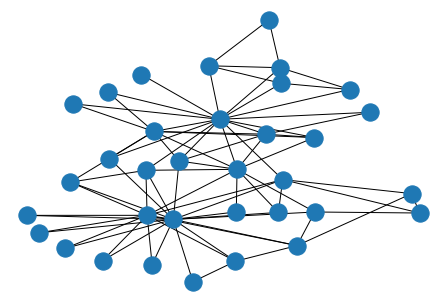

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np
import networkx as nx
G = nx.karate_club_graph()
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos)
adj = np.array(nx.adjacency_matrix(G).todense())

In [13]:
def gcn_adjacency(A):
    A_hat = A + np.eye(len(A))
    D_hat_inv_sqrt = np.diag(1/np.sqrt(A_hat.sum(axis=0)))
    return torch.Tensor(D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt)
    
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Parameter(0.1 * torch.randn(in_features, out_features))
        
    def forward(self, g, x):
        return torch.matmul(g, torch.matmul(x, self.W))
    
    
class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super().__init__()
        self.gcn1 = GCNLayer(in_features, hidden_features)
        self.a1 = nn.ReLU()
        self.gcn2 = GCNLayer(hidden_features, hidden_features)
        self.a2 = nn.ReLU()
        self.gcn3 = GCNLayer(hidden_features, num_classes)
        self.a3 = nn.Sigmoid()
    
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = self.a1(h)
        h = self.gcn2(g, h)
        h = self.a2(h)
        h = self.gcn3(g, h)
        h = self.a3(h)
        return h

In [100]:
points = random.sample(range(34), 4)
label = torch.Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
gcn = GCN(34, 34, 2)
solver = torch.optim.SGD(gcn.parameters(),  lr=1e-1)
A = gcn_adjacency(adj) #GCN message passing matrix
X = torch.eye(34) #input
print(A.shape)
print(X.shape)
print('selected 4 points', points)

torch.Size([34, 34])
torch.Size([34, 34])
selected 4 points [33, 19, 28, 26]


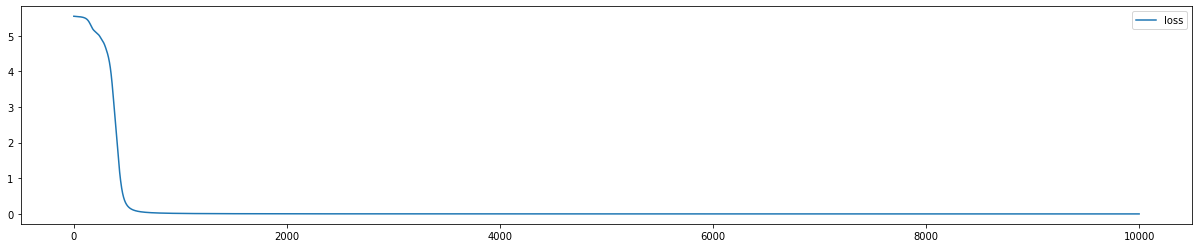

In [101]:
LOSS = []
for epoch in range(10000):
    solver.zero_grad()
    y = gcn(A, X)
    loss = 0.0
    for i in range(len(points)):
        loss += F.binary_cross_entropy(y[points[i]][0], label[i][0]) + F.binary_cross_entropy(y[points[i]][1], label[i][1])
    LOSS.append(loss.item())
    loss.backward()
    solver.step()
plt.figure(figsize=(21, 4))
plt.plot(range(len(LOSS)), LOSS, label='loss')
plt.legend()
plt.show()

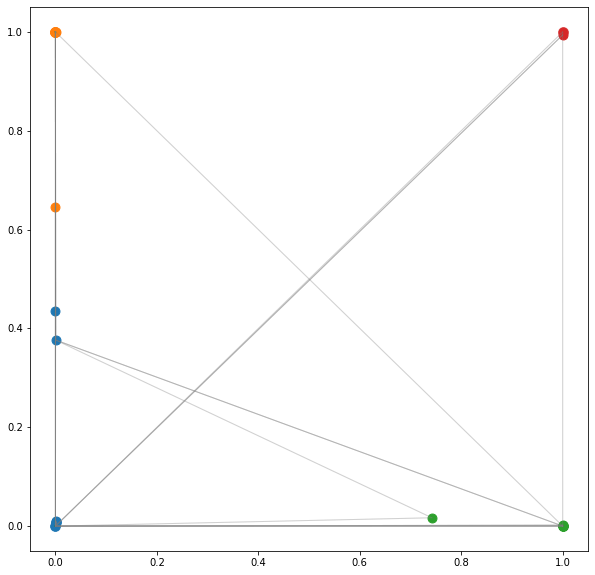

In [126]:
y = gcn(A, X).detach().numpy()
group = []

for i in range(34):
    if y[i][0] > 0.5:
        if y[i][1] > 0.5:
            group.append(0)
        else :
            group.append(1)
    else:
        if y[i][1] > 0.5:
            group.append(2)
        else :
            group.append(3)
        
plt.figure(figsize=(10, 10))
color = {0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red'}



for i in range(34):
    for j in range(34):
        if adj[i][j] == 1:
            plt.plot([y[i][0], y[j][0]], [y[i][1], y[j][1]], c='tab:gray', linewidth=1, alpha=0.2)

for i in range(4):
    g = []
    for j in range(len(group)):
        if group[j] == group[points[i]]:
            g.append(j)
    plt.scatter(y[g, 0], y[g, 1], c=color[i], alpha=1.0, s=80)
    plt.scatter(y[points[i]][0], y[points[i]][1], alpha=0.5, c=color[i], s=100)

plt.show()

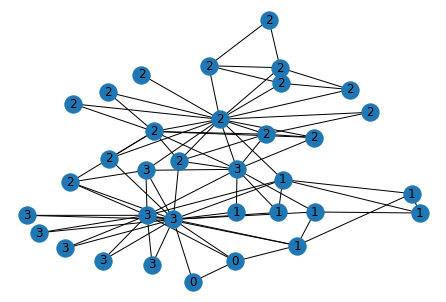

In [148]:
G = nx.karate_club_graph()
pos = nx.kamada_kawai_layout(G)
label = {i: group[i] for i in range(len(group))}
nx.draw(G, pos, labels=label)